****1. Import Libraries****

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

****2.Define Constants****

In [56]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
TRAIN_PATH = "/kaggle/input/brain-tumor-mri-dataset/Training"
TEST_PATH = "/kaggle/input/brain-tumor-mri-dataset/Testing"


**3. Load Dataset and Create DataFrames**

In [57]:
def create_dataframe(data_path):
    classes, class_paths = zip(*[
        (label, os.path.join(data_path, label, image))
        for label in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, label))
        for image in os.listdir(os.path.join(data_path, label))
    ])
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})
train_data = create_dataframe(TRAIN_PATH)
test_data = create_dataframe(TEST_PATH)
print("Train samples:", len(train_data))
print("Test samples:", len(test_data))

Train samples: 5712
Test samples: 1311


**4. Train/Validation Split (Explicit)**

In [58]:
train_df_split, val_df_split = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data['Class'],
    random_state=42
)
print("Train split samples:", len(train_df_split))
print("Validation split samples:", len(val_df_split))

Train split samples: 4569
Validation split samples: 1143


**5. Image Preprocessing & Data Augmentation**

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_split,
    x_col='Class Path',
    y_col='Class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df_split,
    x_col='Class Path',
    y_col='Class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='Class Path',
    y_col='Class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


**6. Callbacks Setup**

In [60]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = "best_model.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

**7. Build Custom CNN Model with BatchNorm & Dropout**

In [61]:
def build_cnn_model(num_classes, optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.001)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=0.001, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    else:
        raise ValueError("Unsupported optimizer")
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model


**8. Build Pretrained Model**

In [62]:
def build_pretrained_model(num_classes, base='vgg16', optimizer='adam'):
    if base == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    elif base == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    elif base == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    else:
        raise ValueError("Unsupported base model")
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=0.0001)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=0.001, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    else:
        raise ValueError("Unsupported optimizer")
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model

**9. Train Custom CNN Model**

In [63]:
num_classes = len(train_gen.class_indices)
model = build_cnn_model(num_classes=num_classes, optimizer='adam')
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,565,380 (36.49 MB)

 Trainable params: 9,564,932 (36.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [64]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.4634 - loss: 5.1370 - precision_8: 0.5091 - recall_8: 0.3842
Epoch 1: val_loss improved from inf to 9.84867, saving model to best_model.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 289ms/step - accuracy: 0.4637 - loss: 5.1200 - precision_8: 0.5096 - recall_8: 0.3840 - val_accuracy: 0.2555 - val_loss: 9.8487 - val_precision_8: 0.2555 - val_recall_8: 0.2555
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5400 - loss: 1.1762 - precision_8: 0.7288 - recall_8: 0.3051
Epoch 2: val_loss improved from 9.84867 to 3.56190, saving model to best_model.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 274ms/step - accuracy: 0.5401 - loss: 1.1758 - precision_8: 0.7288 - recall_8: 0.3052 - val_accuracy: 0.2896 - val_loss: 3.5619 - val_precision_8: 0.2879 - val_recall_8: 0.2843
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5746 - loss: 1.0291 - precision_8: 0.7242 - recall_8: 0.3887
Epoch 3: val_loss improved from 3

**9. Train Pretrained Model**

In [65]:
num_classes = len(train_gen.class_indices)
pretrained_model = build_pretrained_model(num_classes=num_classes, base='vgg16', optimizer='adam')
print(pretrained_model.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [66]:
history_pretrained = pretrained_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3046 - loss: 1.5094 - precision_9: 0.3350 - recall_9: 0.1039
Epoch 1: val_loss did not improve from 0.68269
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.3049 - loss: 1.5086 - precision_9: 0.3357 - recall_9: 0.1039 - val_accuracy: 0.5958 - val_loss: 1.0612 - val_precision_9: 0.9722 - val_recall_9: 0.1837
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5251 - loss: 1.1282 - precision_9: 0.7249 - recall_9: 0.2150
Epoch 2: val_loss did not improve from 0.68269
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.5253 - loss: 1.1279 - precision_9: 0.7251 - recall_9: 0.2152 - val_accuracy: 0.7340 - val_loss: 0.8747 - val_precision_9: 0.9517 - val_recall_9: 0.3106
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6099 - loss: 0.9569 - precision_9: 0.7908 - recall_9: 0.3359
Epoch 3: val_loss did not improve from 0.68269
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - accura

**8. Model Evaluation on Test Set**

In [67]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.55      0.66       300
  meningioma       0.48      0.60      0.53       306
     notumor       0.74      0.97      0.84       405
   pituitary       0.94      0.61      0.74       300

    accuracy                           0.71      1311
   macro avg       0.75      0.68      0.69      1311
weighted avg       0.75      0.71      0.70      1311



In [68]:
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Weighted F1-score:", f1)


Weighted F1-score: 0.7045267154369365


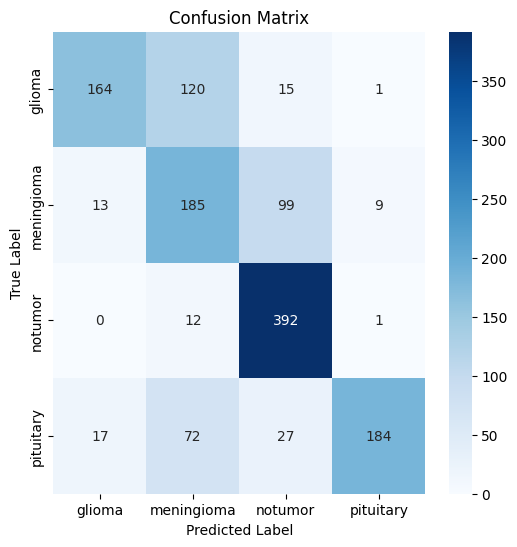

In [69]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

**9.Exploratory Data Analysis (EDA)**

Class distribution in training data:
Class
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


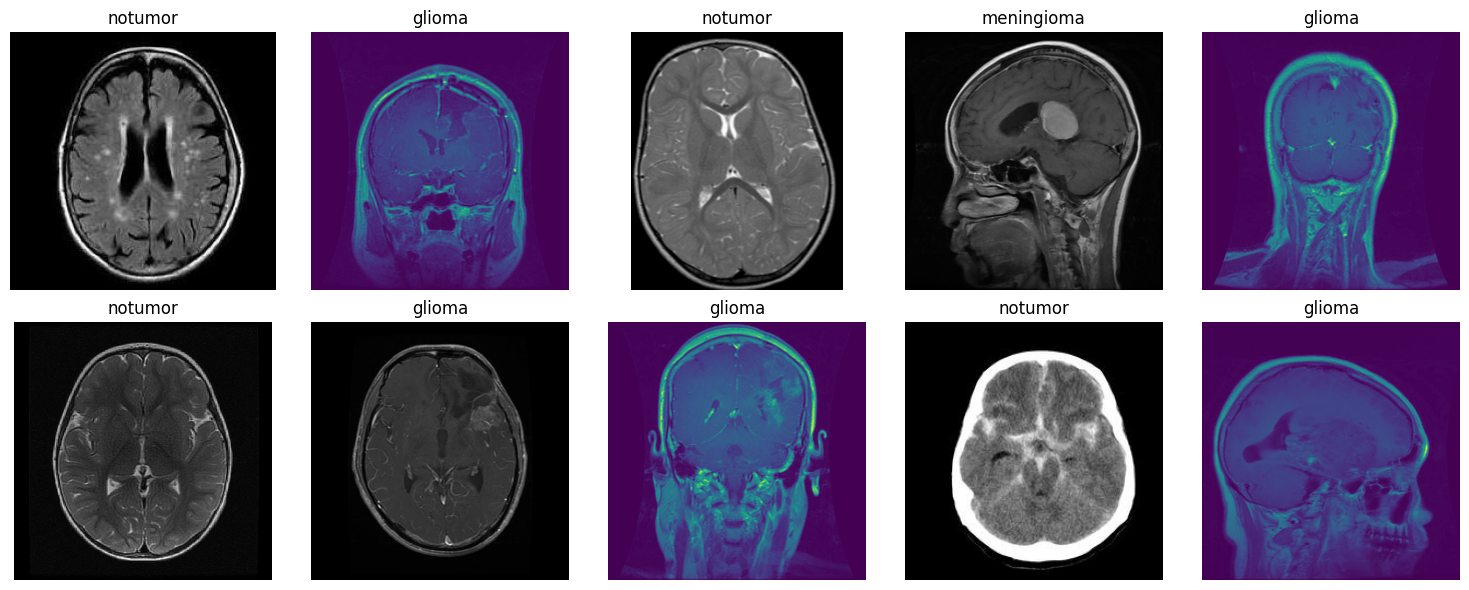

In [70]:
print("Class distribution in training data:")
print(train_data['Class'].value_counts())

import random
from matplotlib.image import imread
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i, ax in enumerate(axes.flatten()):
    sample = train_data.sample(1).iloc[0]
    img = imread(sample['Class Path'])
    ax.imshow(img)
    ax.set_title(sample['Class'])
    ax.axis('off')
plt.tight_layout()
plt.show()

**10.Training and Validation Curves**

In [71]:
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

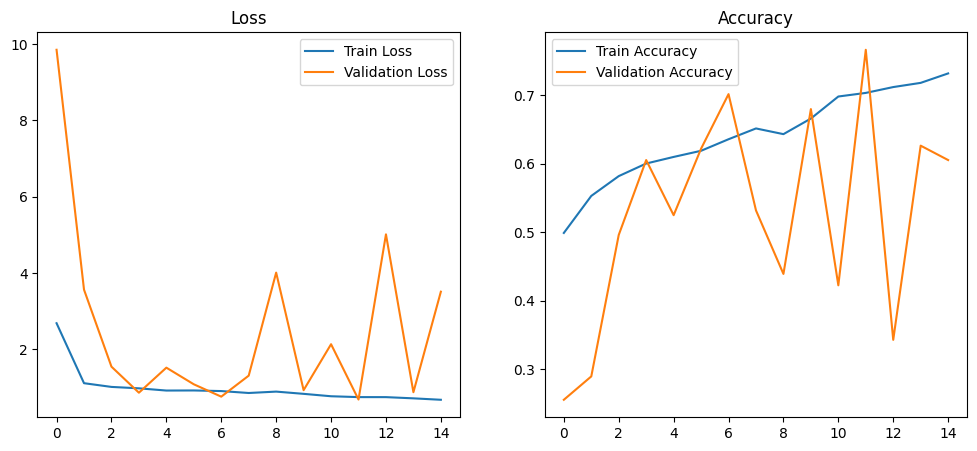

In [72]:
plot_history(history)


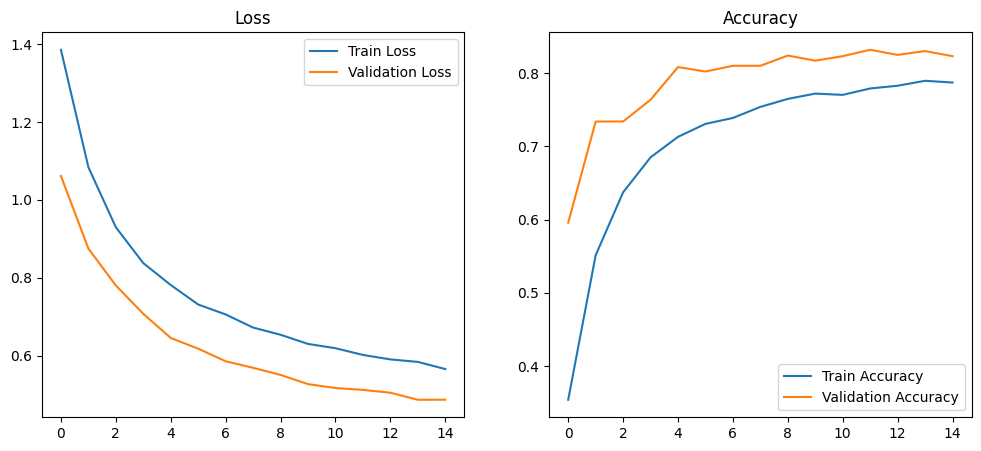

In [73]:
plot_history(history_pretrained)

**11.Experiment with Different Optimizers and Architectures**

In [74]:
def build_cnn_model(num_classes, optimizer='adam', learning_rate=0.0005, dropout_rate=0.5):
  
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        # Example: add an extra Conv2D layer
        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model

model = build_cnn_model(num_classes=num_classes, optimizer='sgd', dropout_rate=0.3, learning_rate=0.001)


**12.Experiment with Hyperparameters**

In [75]:
BATCH_SIZE = 64 

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_split,
    x_col='Class Path',
    y_col='Class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df_split,
    x_col='Class Path',
    y_col='Class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


def build_cnn_model(num_classes, optimizer='adam', learning_rate=0.0005):
   
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model

model = build_cnn_model(num_classes=num_classes, optimizer='adam', learning_rate=0.0005)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


In [76]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5584 - loss: 1.7756 - precision_11: 0.5938 - recall_11: 0.4952
Epoch 1: val_loss did not improve from 0.48626
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 546ms/step - accuracy: 0.5591 - loss: 1.7677 - precision_11: 0.5949 - recall_11: 0.4958 - val_accuracy: 0.2555 - val_loss: 5.3884 - val_precision_11: 0.2555 - val_recall_11: 0.2555
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6976 - loss: 0.7759 - precision_11: 0.7504 - recall_11: 0.6107
Epoch 2: val_loss did not improve from 0.48626
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 503ms/step - accuracy: 0.6979 - loss: 0.7752 - precision_11: 0.7507 - recall_11: 0.6111 - val_accuracy: 0.2555 - val_loss: 7.2554 - val_precision_11: 0.2555 - val_recall_11: 0.2555
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7407 - loss: 0.6540 - precision_11: 0.7907 - recall_11: 0.6758
Epoch 3: val_loss did not improve from 0.48626
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 493ms/step - accu

**13.Evaluate Pretrained Model on Test Set**

In [79]:
y_pred_pretrained = pretrained_model.predict(test_gen)
y_pred_classes_pretrained = np.argmax(y_pred_pretrained, axis=1)
y_true = test_gen.classes

print("Classification Report (Pretrained Model):")
print(classification_report(y_true, y_pred_classes_pretrained, target_names=list(test_gen.class_indices.keys())))
f1_pretrained = f1_score(y_true, y_pred_classes_pretrained, average='weighted')
print("Weighted F1-score (Pretrained Model):", f1_pretrained)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
Classification Report (Pretrained Model):
              precision    recall  f1-score   support

      glioma       0.84      0.72      0.77       300
  meningioma       0.70      0.48      0.57       306
     notumor       0.82      0.92      0.87       405
   pituitary       0.74      0.96      0.84       300

    accuracy                           0.78      1311
   macro avg       0.78      0.77      0.76      1311
weighted avg       0.78      0.78      0.77      1311

Weighted F1-score (Pretrained Model): 0.7705723635054568


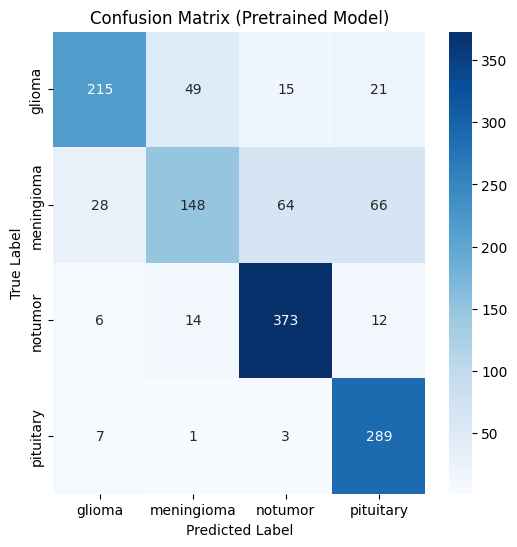

In [80]:
cm_pretrained = confusion_matrix(y_true, y_pred_classes_pretrained)
plt.figure(figsize=(6,6))
sns.heatmap(cm_pretrained, annot=True, fmt='d', cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix (Pretrained Model)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()